Linear transformations - to transform the feature space

- reduce dimensionality - data compression, better vizualization

- feature decorrelation 

- in case of a classification problem, to achieve easier class-separability.

Two techniques: 

- Principal Component Analysis (PCA) - an unsupervised method,

- Linear Discriminant Analysis (LDA) - a supervised method.


PCA: Re-expressing the dataset to extract relevant information embedded in the variance of data samples.

Fundamental idea: the useful information content in the data is represented by the variance of data samples.


We are looking for a projection vector that accounts for as much of the variability in the data as possible after projection. (Projection onto a vector is important here!)


Whitening: an extension of PCA, spherical covariance matrix to obtain scale-invariance. (Avoiding that the values of features influence the variance).


LDA: data with class labels

# PCA - Principal Component Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [71]:
def PCA(X, n_components):
    """
    Perform PCA dimensionality reduction
    :param X: matrix, shape: (n_samples, n_features)
    :param n_components: number of principal components to reduce data to
    :return: X_reduced: matrix, shape (n_samples, n_components),
             sorted_eig_vals: sorted eigenvalues,
             sorted_eig_vecs: sorted eigenvectors       
    """
                                                       # STEPS:
    X_centered = X - np.mean(X, axis=0)                # Center the data      
    cov_mat = np.cov(X_centered, rowvar=False)         # Calculate the covariance matrix
    eig_vals, eig_vecs = np.linalg.eigh(cov_mat)       # Find eigenvalues and eigenvectors for the cov. matrix
    
    key = np.argsort(eig_vals)[::-1]                   # Sort eigenvalues in descending order
    sorted_eig_vals = eig_vals[key]                    # Rearrange eigenvalues based on sorting order   
    sorted_eig_vecs = eig_vecs[:, key]                 # Rearrange feature-dimension of eigenvectors 

    eigvecs_subset = sorted_eig_vecs[:, :n_components] # Take first n_components

    X_reduced = np.dot(X_centered, eigvecs_subset)     # Transform the data 
    return X_reduced, sorted_eig_vals, sorted_eig_vecs


# Remark:
# np.cov with rowvar=False
# If rowvar is True (default), then each row represents a variable, with observations in the columns. 
# Otherwise, the relationship is transposed: each column represents a variable, while the rows contain observations.

(20, 2)


Text(0, 0.5, 'PCA 2')

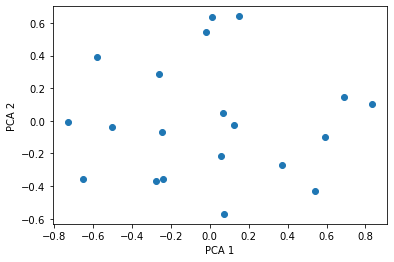

In [61]:
# Example 1
X = np.random.rand(100).reshape(20, 5) 
X_reduced, _, _ = PCA(X, n_components=2)
print(X_reduced.shape)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

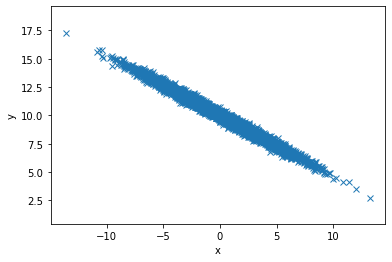

In [62]:
# Example 2
mean = [0, 10]
cov = np.array([[3, -1.5], [-1.5, 1]])  # diagonal covariance
cov = cov @ cov.T # to ensure that it is positive semi-definite
N = 5000

x, y = np.random.multivariate_normal(mean, cov, N).T

plt.plot(x, y, 'x')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

(5000,) (5000,)
X shape:  (5000, 2)
X_reduced shape:  (5000, 1)


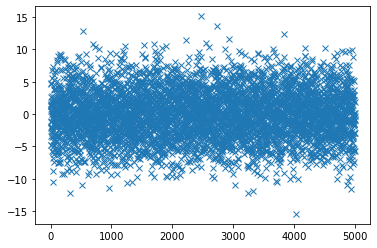

In [63]:
print(x.shape, y.shape)
X = np.vstack((x, y)).T
print('X shape: ', X.shape)

X_reduced, eig_vals, eig_vecs = PCA(X, n_components=1)

print('X_reduced shape: ', X_reduced.shape)

plt.plot(X_reduced, 'x')

In [64]:
# Percentage of variance explained!!! Important to calculate! 
explained_var = eig_vals / np.sum(eig_vals)
print('Explained variance per principal component (sorted): ', explained_var)

# What would be the total variance explained? 
# It is the sum of individual explained variances!

Explained variance per principal component (sorted):  [0.99731351 0.00268649]


In [65]:
print(f'Min: {np.min(X_reduced):.2f}; Max: {np.max(X_reduced):.2f}')

Min: -15.42; Max: 15.12


# Whitening

In [66]:
def PCA_whitening(X, n_components):
    """
    Perform PCA dimensionality reduction
    :param X: matrix, shape: (n_samples, n_features)
    :param n_components: number of principal components to reduce data to
    :return: X_reduced: matrix, shape (n_samples, n_components),
             eig_vals: eigenvalues (already sorted in desc. order),
             eig_vecs: sorted eigenvectors (already sorted in desc. order)      
    """
                                                       # STEPS:
    X_centered = X - np.mean(X, axis=0)                # Center the data      
    cov_mat = np.cov(X_centered, rowvar=False)         # Calculate the covariance matrix
    eig_vals, eig_vecs = np.linalg.eigh(cov_mat)       # Find eigenvalues and eigenvectors for the cov. matrix
    diag_eig_vals_mat = np.diag(eig_vals**(-0.5))      # Calculate L^(-1/2)
    eigvecs_subset = eig_vecs[:, :n_components]        # Take first n_components

                                                       # Transform the data 
    X_reduced = np.dot(np.dot(diag_eig_vals_mat[:n_components, :n_components], eigvecs_subset.T),
                       X_centered.T).T
    return X_reduced

In [67]:
# Example 3
# Perform PCA with whitening and reduce dimension to 1

X_reduced = PCA_whitening(X, n_components=1)
print('X_reduced shape: ', X_reduced.shape)
print(f'Min: {np.min(X_reduced):.2f}; Max: {np.max(X_reduced):.2f}')

X_reduced shape:  (5000, 1)
Min: -3.54; Max: 3.65


X_reduced shape:  (5000, 2)
Min: -3.95; Max: 4.03


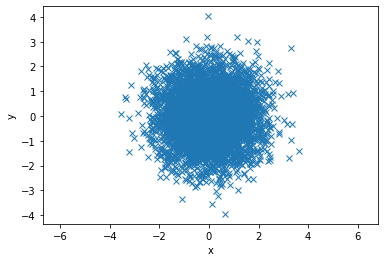

In [68]:
# Example 4 
# Perform PCA with whitening and keep dimension of 2

X_reduced = PCA_whitening(X, n_components=2)
print('X_reduced shape: ', X_reduced.shape)
print(f'Min: {np.min(X_reduced):.2f}; Max: {np.max(X_reduced):.2f}')

plt.plot(X_reduced[:, 0], X_reduced[:, 1], 'x')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# LDA

In [69]:
def LDA(X, y, n_components):
    # Within-class covariance:
    # Sw = sum_over_c((Xc - mean_Xc) * (Xc - mean_Xc)^T)

    # Between-class covariance:
    # Sb = sum_over_c(nc * (mean_Xc - mean_overall) * (mean_Xc - mean_overall)^T )

    n_features = X.shape[1]
    class_labels = np.unique(y)

    overall_mean = np.mean(X, axis=0)

    Sw = np.zeros((n_features, n_features))
    Sb = np.zeros((n_features, n_features))

    for c in (class_labels):
        Xc = X[y == c]
        class_mean_per_feature = np.mean(Xc, axis=0)
        Sw += (Xc - class_mean_per_feature).T.dot((Xc - class_mean_per_feature)) # shape (n_feature, n_feature)

        n_per_class = Xc.shape[0]
        mean_diff = (class_mean_per_feature - overall_mean).reshape((-1, 1))
        Sb += n_per_class * (mean_diff).dot(mean_diff.T) # shape (n_feature, n_feature)


    # Calculate Sw^-1 * Sb and decompose it
    A = np.linalg.inv(Sw).dot(Sb)
    eig_vals, eig_vecs = np.linalg.eig(A)

    key = np.argsort(eig_vals)[::-1]   
    sorted_eig_vals = eig_vals[key]                   
    sorted_eig_vecs = eig_vecs[key]   

    eigvecs_subset = sorted_eig_vecs[:, :n_components]

    X_reduced = np.dot(X, eigvecs_subset)  
    return X_reduced

(150, 4)


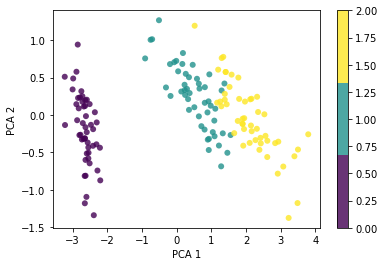

(150, 4)


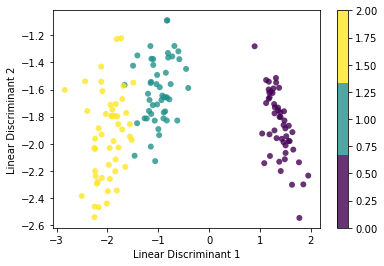

In [70]:
from sklearn import datasets
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

data = datasets.load_iris()
X = data.data
y = data.target

print(X.shape)

n_components = 2
X_pca_reduced, _, _ = PCA(X, n_components)
plt.scatter(X_pca_reduced[:, 0], 
            X_pca_reduced[:, 1],
            c=y, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('viridis', 3))

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


print(X.shape)
X_lda_reduced = LDA(X, y, n_components)

plt.scatter(X_lda_reduced[:, 0], 
            X_lda_reduced[:, 1],
            c=y, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('viridis', 3))

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.colorbar()
plt.show()

In [32]:
# Or simply use: 
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html